In [1]:
%load_ext autoreload
%autoreload 2

# TODO:

Make a image based table extractor.
- use hamilton for reproducability
- takes a folder with a set of images
- or takes a list of filenames for images
- calls LLM to convert to a csv format
- loads csv into pandas
- can have some custom cleaning rules
    - identify label cols, other cols
- concatenates them accordingly
    - check that all label columns are the same
    - concatenate horizontally (multipage tables)
- export to a single csv file

## Vertical table from png

### TODO: Estimate price

From Claude:

> Each image you include in a request to Claude counts towards your token usage. To calculate the approximate cost, multiply the approximate number of image tokens by the per-token price of the model you’re using.
> 
> If your image does not need to be resized, you can estimate the number of tokens used through this algorithm: tokens = (width px * height px)/750
> 
> Here are examples of approximate tokenization and costs for different image sizes within our API’s size constraints based on Claude 3.5 Sonnet per-token price of `$3 per million input tokens`:
> 
> `Image size	# of Tokens	Cost / image	Cost / 1K images`  
> `200x200 px(0.04 megapixels)	~54	~$0.00016	~$0.16`  
> `1000x1000 px(1 megapixel)	~1334	~$0.004	~$4.00`  
> `1092x1092 px(1.19 megapixels)	~1590	~$0.0048	~$4.80`  



In [26]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if openai_api_key and anthropic_api_key:
   print("API key loaded successfully!")
else:
   print("Failed to load API key. Check your .env file.")

API key loaded successfully!


In [54]:
import pandas as pd
import pathlib
from PIL import Image
from IPython.display import Image as IPythonImage
import base64
from io import BytesIO
import anthropic
import json
from io import StringIO
from typing import Union


def load_png(filepath: str) -> Image.Image:
    """
    Load a PNG file from the given filepath.
    
    Args:
        filepath (str): Path to the PNG file.
    
    Returns:
        Image.Image: Loaded image object.
    """
    return Image.open(filepath)

def encode_png(img: Image.Image) -> str:
    """
    Encode a PIL Image object to base64 for input to APIs.
    
    Args:
        img (Image.Image): Loaded image object.
    
    Returns:
        str: Base64 encoded string of the image.
    """
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def identify_image_table(encoded_img: str, table_information:str | None=None) -> str:
    """
    Send the encoded image to Claude for analysis and return a CSV string.
    
    Args:
        encoded_image (str): Base64 encoded image string.
        table_information : optional information about the table to help parsing
    
    Returns:
        str: CSV formatted string of the table contents.
    """
    system = "You are an expert at image analysis and extracting data from images of tables. You respond concisely and do not explain your answers."

    if table_information is not None:
        information = f"""Some information about the table:

        {table_information}
        """
    else:
        information = "" 
    
    prompt = f"""Please analyze the image and return its contents as a CSV formatted string. Use the <image_information> to help you.
    
    <image_information>
    The image is base64 encoded and contains a table.
    
    {table_information}
    </image_information>
    
    Provide your answer in JSON format with the following keys: 
    - "description" containing a concise description of the image
    - "data" containing a string of the table in CSV format
    - "completeness"  a string indicating how well the analysis went. Use one of ['success','warning','fail']

    If you can't determine the data use 'fail' in the completeness field. If you have trouble analyzing the table but obtained values use 'warning' in the completeness field.
    """
   
    img_media_type = "image/png"
    img_data = encoded_img
    
    message_content = [
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": img_media_type,
                "data": img_data,
            },
        },
        {
            "type": "text",
            "text": prompt,
        },
    ]
    message = {"role": "user", "content": message_content}

    client = anthropic.Client()
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=4096,
        system=system,
        messages=[message],
        temperature=0.0,
    )

    try:
        result = json.loads(response.content[-1].text)
        description = result.get("description","")
        data = result.get("data",""),
        completeness = result.get("completeness", "fail")
    except json.JSONDecodeError:
        print("Error: Unable to parse JSON response from Claude")
        description = ""
        data = ""
        completeness = "fail"

    #validate
    if data == "":
        completeness = "fail"
    
    parsed_data = {
        "description" : description,
        "data" : data,
        "completeness" : completeness
    }
    return parsed_data

def csv_data_to_dataframe(csv_data: Union[str, tuple, list]) -> pd.DataFrame:
    """
    Convert a CSV formatted string or tuple to a pandas DataFrame.
    
    Args:
        csv_data (Union[str, tuple]): CSV formatted string or tuple containing the CSV string.
    
    Returns:
        pd.DataFrame: Pandas DataFrame containing the CSV data.
    
    Raises:
        ValueError: If the CSV string is empty or cannot be parsed.
        TypeError: If the input is neither a string nor a tuple.
    """
    if isinstance(csv_data, tuple) or isinstance(csv_data, list):
        if len(csv_data) == 0:
            raise ValueError("The input tuple/list is empty.")
        csv_string = csv_data[0]
    elif isinstance(csv_data, str):
        csv_string = csv_data
    else:
        raise TypeError("Input must be a string or a tuple.")

    if not isinstance(csv_string, str):
        raise TypeError("The CSV data must be a string.")

    if not csv_string.strip():
        raise ValueError("The CSV string is empty.")
    
    try:
        # Use StringIO to create a file-like object from the string
        csv_io = StringIO(csv_string)
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(csv_io, skipinitialspace=True)
        
        # Check if the DataFrame is empty
        if df.empty:
            raise ValueError("The CSV string did not produce any valid data.")
        
        return df
    
    except pd.errors.EmptyDataError:
        raise ValueError("The CSV string is empty or contains only whitespace.")
    except pd.errors.ParserError as e:
        raise ValueError(f"Failed to parse the CSV string: {str(e)}")

In [55]:
data_dir = pathlib.Path('../+knowledge/table_imgs')
filenames = []
for p in data_dir.iterdir():
    if p.suffix in ['.png']:
        filenames.append(str(p.name))
filenames = sorted(filenames)
display(filenames)

['table30-a.png',
 'table30-b.png',
 'table30-c.png',
 'table30-d.png',
 'table30-e.png',
 'table30-f.png',
 'table30-g.png',
 'table30-h.png',
 'table30-i.png',
 'table30-j.png',
 'table30-k.png',
 'table30-l.png',
 'table30-m.png']

In [92]:
data = pd.DataFrame()
imgs = {}
for i, filename in enumerate(filenames):
    print(filename)
    # Load image
    filepath = data_dir / filename
    img = load_png(filepath)
    img_encoded = encode_png(img)
    img_data = {
        'filepath' : str(filepath.resolve),
        'img': img, 
        'encoded' : img_encoded
    }
    #parse image with LLM
    table_information="""The table has a column missing a header after the 'installed cost(all units). It contains equipment labels (e.g. D-101, E-400, etc.). Add a header 'label' for this column.

    Some values may include commas (e.g. 1,000 to denote larger numbers), if this is the case then make sure to remove the commas from the value. for example if you find '1,000' it should become 1000
    """
    
    try:
        parsed_data = identify_image_table(
            encoded_img=img_encoded,
            table_information=table_information
        )
        csv_data = parsed_data['data']
        df = csv_data_to_dataframe(csv_data)
        img_data.update({
            'description' : parsed_data['description'],
            'data' :df,
            'completeness' : parsed_data['completeness'],
        })
        print(f"- shape: {df.shape}")
        print(f"- headers : {df.columns.tolist()}")
        df.to_csv(filepath.with_suffix(".csv"))
    except Exception as e:
        print("Failed to parse image due to:")
        print(e)
    imgs[filename] = img_data

table30-a.png
- shape: (2, 6)
- headers : ['FOB (1 Unit)', 'FOB (All Units)', 'Instal (1 Unit)', 'Installed Cost (All Units)', 'Label', 'Floor Area (ft2)']
table30-b.png
- shape: (1, 8)
- headers : ['FOB (1 Unit)', 'FOB (All Units)', 'Instal (1 Unit)', 'Instal (All Units)', 'Installed Cost (All Units)', 'label', 'SOLIDS CONVEYORS', '# Installed']
table30-c.png
- shape: (17, 6)
- headers : ['FOB (1 Unit)', 'FOB (All Units)', 'Instal (1 Unit)', 'Instal (All Units)', 'Installed Cost (All Units)', 'label']
table30-d.png
- shape: (20, 5)
- headers : ['FOB (1 Unit)', 'FOB (All Units)', 'Instal (1 Unit)', 'Installed Cost (All Units)', 'label']
table30-e.png
- shape: (1, 8)
- headers : ['FOB (1 Unit)', 'FOB (All Units)', 'Instal (1 Unit)', 'Instal (All Units)', 'Installed Cost (All Units)', 'label', 'FIRED HEATERS', '# Installed']
table30-f.png
- shape: (7, 8)
- headers : ['FOB (1 Unit)', 'FOB (All Units)', 'Instal (1 Unit)', 'Instal (All Units)', 'Installed Cost (All Units)', 'label', 'FILTER

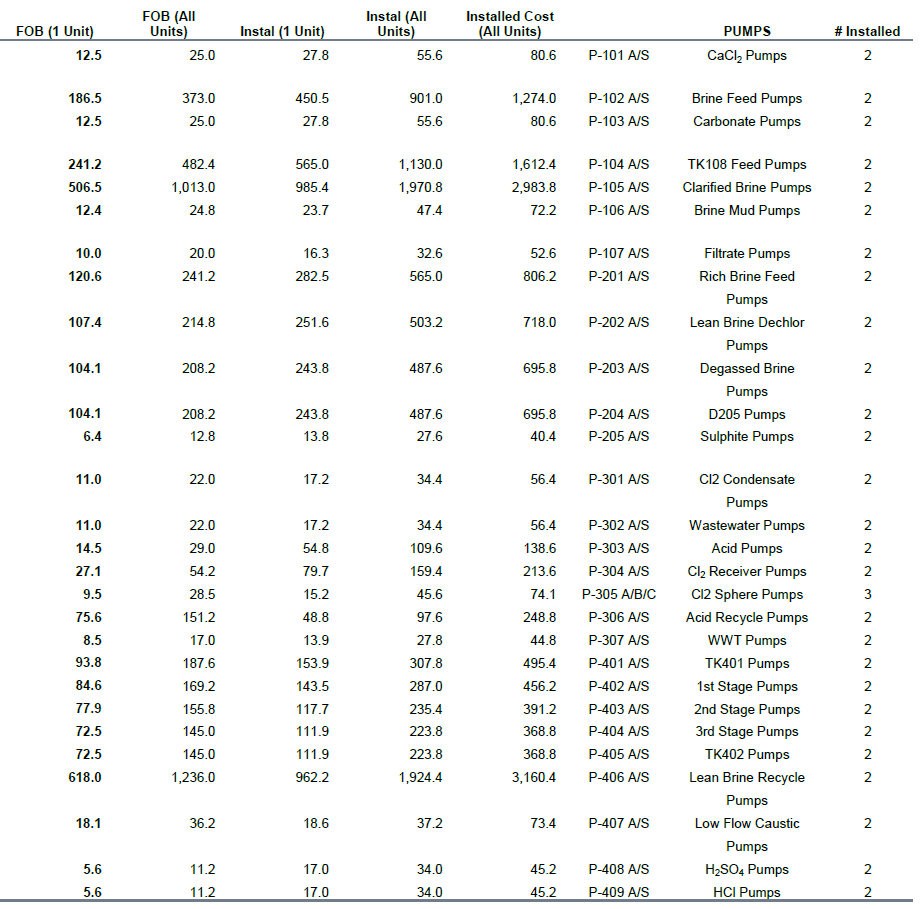

The image contains a table with information about various pumps, including their FOB (Free on Board) cost, installation cost, and other details.
('FOB (1 Unit),FOB (All Units),Instal (1 Unit),Instal (All Units),Installed Cost (All Units),label,PUMPS,# Installed\n12.5,25.0,27.8,55.6,80.6,P-101 A/S,CaCl2 Pumps,2\n186.5,373.0,450.5,901.0,1274.0,P-102 A/S,Brine Feed Pumps,2\n12.5,25.0,27.8,55.6,80.6,P-103 A/S,Carbonate Pumps,2\n241.2,482.4,566.0,1130.0,1612.4,P-104 A/S,TK108 Feed Pumps,2\n506.5,1013.0,985.4,1970.8,2983.8,P-105 A/S,Clarified Brine Pumps,2\n12.4,24.8,23.7,47.4,72.2,P-106 A/S,Brine Mud Pumps,2\n10.0,20.0,16.3,32.6,52.6,P-107 A/S,Filtrate Pumps,2\n120.6,241.2,282.5,565.0,806.2,P-201 A/S,Rich Brine Feed Pumps,2\n107.4,214.8,251.6,503.2,718.0,P-202 A/S,Lean Brine Dechlor Pumps,2\n104.1,208.2,243.8,487.6,695.8,P-203 A/S,Degassed Brine Pumps,2\n104.1,208.2,243.8,487.6,695.8,P-204 A/S,D205 Pumps,2\n6.4,12.8,13.8,27.6,40.4,P-205 A/S,Sulphite Pumps,2\n11.0,22.0,17.2,34.4,56.4,P-301 A

In [99]:
filename = 'table30-j.png'
table_information="""The table has a column missing a header after the 'Installed Cost (All Units). That column contains equipment labels (e.g. D-101, E-400, etc.). Add a header 'label' for this column.

Some values may include commas (e.g. 1,000 to denote larger numbers), if this is the case then make sure to remove the commas from the value. for example if you find '1,000' it should become 1000
"""
filepath = data_dir / filename
img = load_png(filepath)
img_encoded = encode_png(img)
display(img)

encoded_img =img_encoded
system = "You are an expert at image analysis and extracting data from images of tables. You respond concisely and do not explain your answers."

if table_information is not None:
    information = f"""Some information about the table:

    {table_information}
    """
else:
    information = "" 

prompt = f"""Please analyze the image and return its contents as a CSV formatted string. Use the <image_information> to help you.

<image_information>
The image is base64 encoded and contains a table.

{table_information}
</image_information>

Provide your answer in JSON format with the following keys: 
- "description" containing a concise description of the image
- "data" containing a string of the table in CSV format
- "completeness"  a string indicating how well the analysis went. Use one of ['success','warning','fail']

If you can't determine the data use 'fail' in the completeness field. If you have trouble analyzing the table but obtained values use 'warning' in the completeness field.
"""

img_media_type = "image/png"
img_data = encoded_img

message_content = [
    {
        "type": "image",
        "source": {
            "type": "base64",
            "media_type": img_media_type,
            "data": img_data,
        },
    },
    {
        "type": "text",
        "text": prompt,
    },
]
message = {"role": "user", "content": message_content}

client = anthropic.Client()
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=4096,
    system=system,
    messages=[message],
    temperature=0.0,
)

try:
    result = json.loads(response.content[-1].text)
    description = result.get("description","")
    data = result.get("data",""),
    completeness = result.get("completeness", "fail")
except Exception as e:
    print(description)
    print(data)
    print(completeness)
try:
    df = csv_data_to_dataframe(data)
    df.to_csv(filepath.with_suffix(".csv"))
    display(df)
except Exception as e:
    print(e)
    print(data[0])


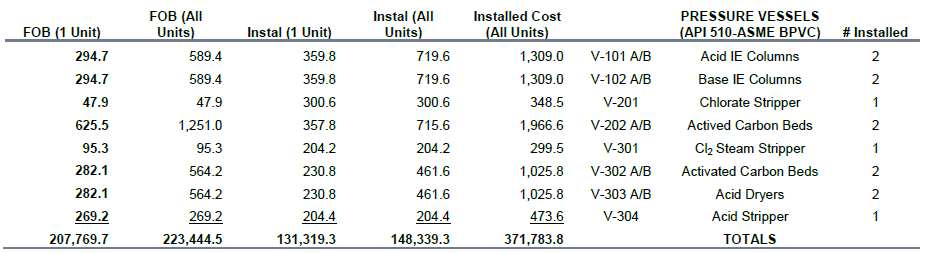

,FOB (1 Unit),FOB (All Units),Install (1 Unit),Install (All Units),Installed Cost (All Units),label,PRESSURE VESSELS (API 510-ASME PVDC),# Installed
0,294.7,589.4,359.8,719.6,1309.0,V-101 A/B,2.0,NaN
1,94.7,589.4,353.8,719.6,1309.0,V-102 A/B,2.0,NaN
2,47.9,47.9,300.6,300.6,348.5,V-201,1.0,NaN
3,625.5,1251.0,357.8,715.6,1966.6,V-202 A/B,2.0,NaN
4,95.3,95.3,204.2,204.2,299.5,V-301,1.0,NaN
5,282.1,564.2,230.8,461.6,1025.8,V-302 A/B,2.0,NaN
6,282.1,564.2,230.8,461.6,1025.8,V-303 A/B,2.0,NaN
7,263.2,269.2,204.4,204.4,473.6,V-304,1.0,NaN
8,207769.7,223444.5,131319.3,148339.3,371783.8,TOTALS,NaN,NaN


In [104]:
filename = 'table30-m.png'
table_information="""The table has a column missing a header after the 'Installed Cost (All Units). That column contains equipment labels (e.g. D-101, E-400, etc.). Add a header 'label' for this column.

Some values may include commas (e.g. 1,000 to denote larger numbers), if this is the case then make sure to remove the commas from the value. for example if you find '1,000' it should become 1000
"""
filepath = data_dir / filename
img = load_png(filepath)
img_encoded = encode_png(img)
display(img)

encoded_img =img_encoded
system = "You are an expert at image analysis and extracting data from images of tables. You respond concisely and do not explain your answers."

if table_information is not None:
    information = f"""Some information about the table:

    {table_information}
    """
else:
    information = "" 

prompt = f"""Please analyze the image and return its contents as a CSV formatted string. Use the <image_information> to help you.

<image_information>
The image is base64 encoded and contains a table.

{table_information}
</image_information>

Provide your answer in JSON format with the following keys: 
- "description" containing a concise description of the image
- "data" containing a string of the table in CSV format
- "completeness"  a string indicating how well the analysis went. Use one of ['success','warning','fail']

If you can't determine the data use 'fail' in the completeness field. If you have trouble analyzing the table but obtained values use 'warning' in the completeness field.
"""

img_media_type = "image/png"
img_data = encoded_img

message_content = [
    {
        "type": "image",
        "source": {
            "type": "base64",
            "media_type": img_media_type,
            "data": img_data,
        },
    },
    {
        "type": "text",
        "text": prompt,
    },
]
message = {"role": "user", "content": message_content}

client = anthropic.Client()
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=4096,
    system=system,
    messages=[message],
    temperature=0.0,
)

try:
    result = json.loads(response.content[-1].text)
    description = result.get("description","")
    data = result.get("data",""),
    completeness = result.get("completeness", "fail")
except Exception as e:
    print(description)
    print(data)
    print(completeness)
try:
    df = csv_data_to_dataframe(data)
    df.to_csv(filepath.with_suffix(".csv"))
    display(df)
except Exception as e:
    print(e)
    print(data[0])


In [109]:
def get_stream_cols(df):
    stream_cols = [col for col in df.columns if 'unit' in col.lower()]
    return stream_cols

def get_label_cols(df):
    label_cols = [col for col in df.columns if 'label' in col.lower()]
    return label_cols

In [120]:
data_dir = pathlib.Path('../+knowledge/table_imgs')
filenames = []
for p in data_dir.iterdir():
    if p.suffix in ['.csv']:
        filenames.append(str(p.name))
filenames = sorted(filenames)

data = pd.DataFrame()
for i, filename in enumerate(filenames):
    print(filename)
    filepath = data_dir / filename
    df = pd.read_csv(filepath, sep=",", index_col=0)
    # print(f"-shape: {df.shape}")
    # display(df)
    stream_cols = get_stream_cols(df)
    label_cols = get_label_cols(df)
    # print(f"- label: {label_cols}")
    # print(f"- info: {stream_cols}")
    #rename columns
    df = df[label_cols+stream_cols]
    df = df.rename(columns={
        col : col.lower()
        for col in label_cols+stream_cols
    })
    data = pd.concat([data,df],axis=0)
    
data.to_csv('table_capex.csv')
display(data)


table30-a.csv
table30-b.csv
table30-c.csv
table30-d.csv
table30-e.csv
table30-f.csv
table30-g.csv
table30-h.csv
table30-i.csv
table30-j.csv
table30-k.csv
table30-l.csv
table30-m.csv


,label,fob (1 unit),fob (all units),instal (1 unit),installed cost (all units),instal (all units),install (1 unit),install (all units)
0,B-101,570.7,1500.0,697.5,3000.0,NaN,NaN,NaN
1,B-102,500.0,500.0,750.0,750.0,NaN,NaN,NaN
0,CV-101,375.0,375.0,615.0,990.0,615.0,NaN,NaN
0,D-201A/B Lean Brine Degasser,728.6,1457.2,207.9,1873.0,415.8,NaN,NaN
1,D-202 Chlorate Drum,231.0,1231.0,213.0,1444.0,213.0,NaN,NaN
...,...,...,...,...,...,...,...,...
4,V-301,95.3,95.3,NaN,299.5,NaN,204.2,204.2
5,V-302 A/B,282.1,564.2,NaN,1025.8,NaN,230.8,461.6
6,V-303 A/B,282.1,564.2,NaN,1025.8,NaN,230.8,461.6
7,V-304,263.2,269.2,NaN,473.6,NaN,204.4,204.4


In [ ]:
dd = data[['label','fob (1 unit)']]

# Horizontal material flow

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if openai_api_key and anthropic_api_key:
   print("API key loaded successfully!")
else:
   print("Failed to load API key. Check your .env file.")

API key loaded successfully!


In [2]:
import pandas as pd
import pathlib
from PIL import Image
from IPython.display import Image as IPythonImage
import base64
from io import BytesIO
import anthropic
import json
from io import StringIO
from typing import Union


def load_png(filepath: str) -> Image.Image:
    """
    Load a PNG file from the given filepath.
    
    Args:
        filepath (str): Path to the PNG file.
    
    Returns:
        Image.Image: Loaded image object.
    """
    return Image.open(filepath)

def encode_png(img: Image.Image) -> str:
    """
    Encode a PIL Image object to base64 for input to APIs.
    
    Args:
        img (Image.Image): Loaded image object.
    
    Returns:
        str: Base64 encoded string of the image.
    """
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def identify_image_table(encoded_img: str, table_information:str | None=None) -> str:
    """
    Send the encoded image to Claude for analysis and return a CSV string.
    
    Args:
        encoded_image (str): Base64 encoded image string.
        table_information : optional information about the table to help parsing
    
    Returns:
        str: CSV formatted string of the table contents.
    """
    system = "You are an expert at image analysis and extracting data from images of tables. You respond concisely and do not explain your answers."

    if table_information is not None:
        information = f"""Some information about the table:

        {table_information}
        """
    else:
        information = "" 
    
    prompt = f"""Please analyze the image and return its contents as a CSV formatted string. Use the <image_information> to help you.
    
    <image_information>
    The image is base64 encoded and contains a table.
    
    {table_information}
    </image_information>
    
    Provide your answer in JSON format with the following keys: 
    - "description" containing a concise description of the image
    - "data" containing a string of the table in CSV format
    - "completeness"  a string indicating how well the analysis went. Use one of ['success','warning','fail']

    If you can't determine the data use 'fail' in the completeness field. If you have trouble analyzing the table but obtained values use 'warning' in the completeness field.
    """
   
    img_media_type = "image/png"
    img_data = encoded_img
    
    message_content = [
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": img_media_type,
                "data": img_data,
            },
        },
        {
            "type": "text",
            "text": prompt,
        },
    ]
    message = {"role": "user", "content": message_content}

    client = anthropic.Client()
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=4096,
        system=system,
        messages=[message],
        temperature=0.0,
    )

    try:
        result = json.loads(response.content[-1].text)
        description = result.get("description","")
        data = result.get("data",""),
        completeness = result.get("completeness", "fail")
    except json.JSONDecodeError:
        print("Error: Unable to parse JSON response from Claude")
        description = ""
        data = ""
        completeness = "fail"

    #validate
    if data == "":
        completeness = "fail"
    
    parsed_data = {
        "description" : description,
        "data" : data,
        "completeness" : completeness
    }
    return parsed_data

def csv_data_to_dataframe(csv_data: Union[str, tuple, list]) -> pd.DataFrame:
    """
    Convert a CSV formatted string or tuple to a pandas DataFrame.
    
    Args:
        csv_data (Union[str, tuple]): CSV formatted string or tuple containing the CSV string.
    
    Returns:
        pd.DataFrame: Pandas DataFrame containing the CSV data.
    
    Raises:
        ValueError: If the CSV string is empty or cannot be parsed.
        TypeError: If the input is neither a string nor a tuple.
    """
    if isinstance(csv_data, tuple) or isinstance(csv_data, list):
        if len(csv_data) == 0:
            raise ValueError("The input tuple/list is empty.")
        csv_string = csv_data[0]
    elif isinstance(csv_data, str):
        csv_string = csv_data
    else:
        raise TypeError("Input must be a string or a tuple.")

    if not isinstance(csv_string, str):
        raise TypeError("The CSV data must be a string.")

    if not csv_string.strip():
        raise ValueError("The CSV string is empty.")
    
    try:
        # Use StringIO to create a file-like object from the string
        csv_io = StringIO(csv_string)
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(csv_io, skipinitialspace=True)
        
        # Check if the DataFrame is empty
        if df.empty:
            raise ValueError("The CSV string did not produce any valid data.")
        
        return df
    
    except pd.errors.EmptyDataError:
        raise ValueError("The CSV string is empty or contains only whitespace.")
    except pd.errors.ParserError as e:
        raise ValueError(f"Failed to parse the CSV string: {str(e)}")

In [3]:
data_dir = pathlib.Path('../+knowledge/table-26-material-flow')
filenames = []
for p in data_dir.iterdir():
    if p.suffix in ['.png']:
        filenames.append(str(p.name))
filenames = sorted(filenames)
display(filenames)

['table-a.png', 'table-b.png', 'table-c.png', 'table-d.png']

table-a.png


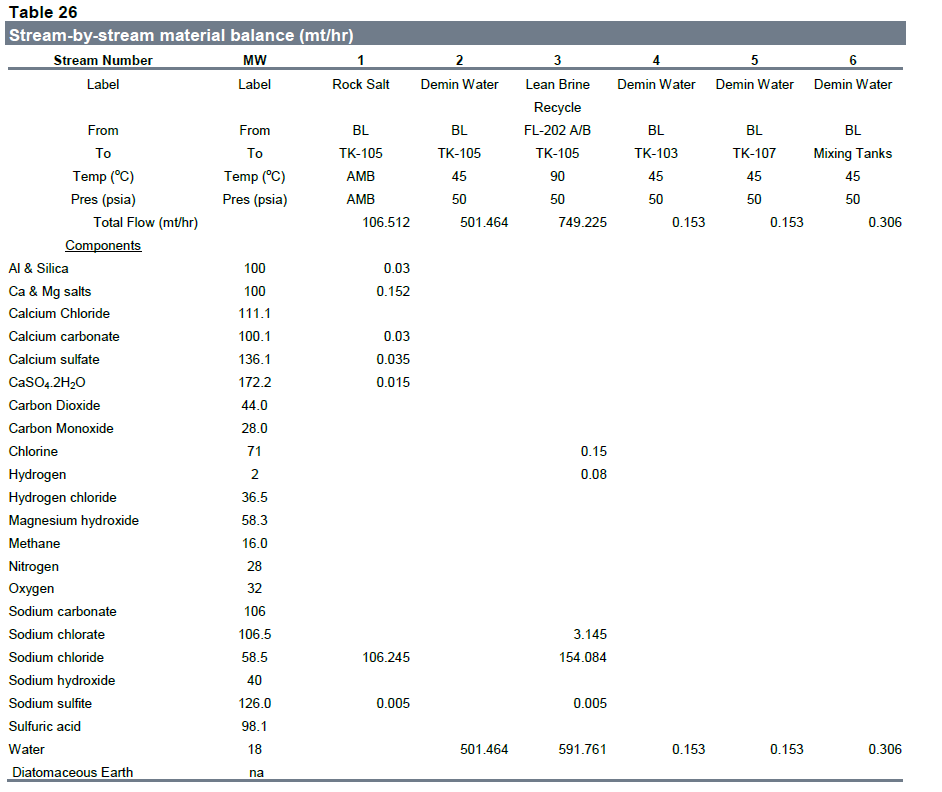

Failed to parse image due to:
Failed to parse the CSV string: Error tokenizing data. C error: Expected 8 fields in line 8, saw 9

table-b.png


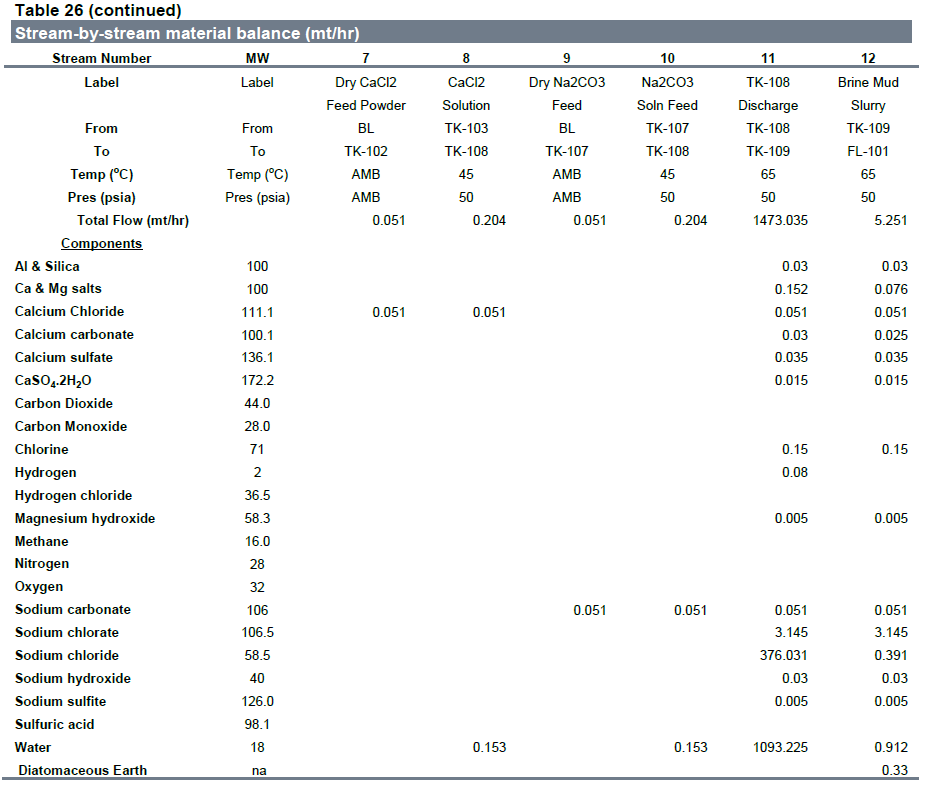

Failed to parse image due to:
Failed to parse the CSV string: Error tokenizing data. C error: Expected 8 fields in line 8, saw 9

table-c.png


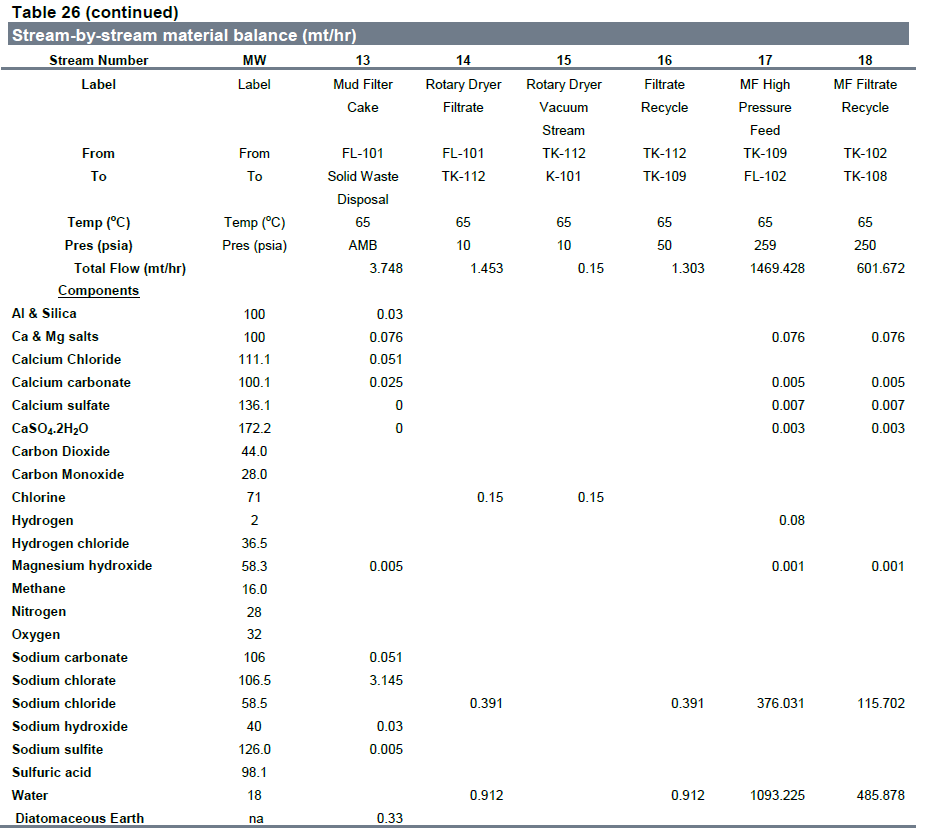

Failed to parse image due to:
Failed to parse the CSV string: Error tokenizing data. C error: Expected 8 fields in line 9, saw 9

table-d.png


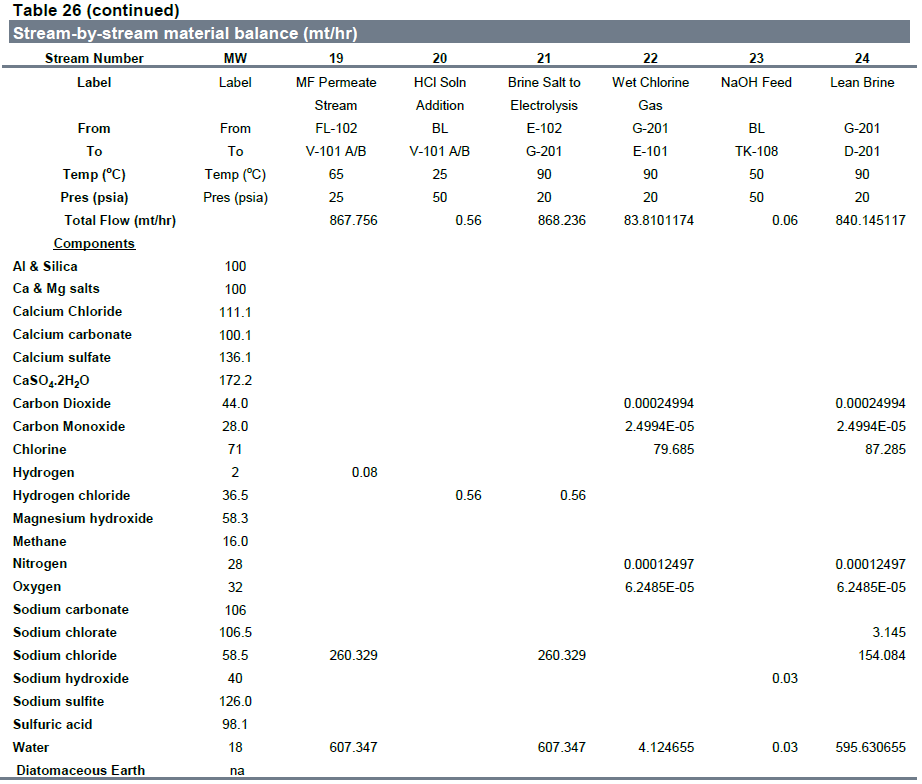

Failed to parse image due to:
Failed to parse the CSV string: Error tokenizing data. C error: Expected 8 fields in line 8, saw 9



In [4]:
data = pd.DataFrame()
imgs = {}
for i, filename in enumerate(filenames):
    print(filename)
    # Load image
    filepath = data_dir / filename
    img = load_png(filepath)
    img_encoded = encode_png(img)
    img_data = {
        'filepath' : str(filepath.resolve),
        'img': img, 
        'encoded' : img_encoded
    }
    display(img)
    #parse image with LLM
    table_information="""The image has a title of the table. under the title is a subtitle with a description of the table
    
    The table has one row in it with a text value 'components' in first column and empty values for all other columns.
    """
    try:
        parsed_data = identify_image_table(
            encoded_img=img_encoded,
            table_information=table_information
        )
        csv_data = parsed_data['data']
        df = csv_data_to_dataframe(csv_data)
        img_data.update({
            'description' : parsed_data['description'],
            'data' :df,
            'completeness' : parsed_data['completeness'],
        })
        print(f"- shape: {df.shape}")
        print(f"- headers : {df.columns.tolist()}")
        df.to_csv(filepath.with_suffix(".csv"))
    except Exception as e:
        print("Failed to parse image due to:")
        print(e)
    imgs[filename] = img_data

# Working

## Horizontal table

In [6]:
import pandas as pd
import pathlib


data_dir = pathlib.Path('../+knowledge/table-26-material-flow')
filenames = []
for p in data_dir.iterdir():
    if p.suffix in ['.csv']:
        filenames.append(str(p.name))
filenames = sorted(filenames)
display(filenames)

['table-a.csv', 'table-b.csv', 'table-c.csv', 'table-d.csv']

In [7]:
def get_stream_cols(df):
    stream_cols = [ col for col in df.columns if col.isdigit()]
    return stream_cols

def get_label_cols(df):
    label_cols = [ col for col in df.columns if not col.isdigit()]
    return label_cols

In [9]:
data = pd.DataFrame()
for i, filename in enumerate(filenames):
    print(i)
    filepath = data_dir / filename
    df = pd.read_csv(filepath, sep=",",)
    stream_cols = get_stream_cols(df)
    label_cols = get_label_cols(df)
    if i==0:
        #first pass take labels
        data = pd.concat([data,df])
    else:
        data = pd.concat([data,df[stream_cols]],axis=1)
display(data)

0


ParserError: Error tokenizing data. C error: Expected 8 fields in line 8, saw 9
